# Dimensionality Reduction

### August 10, 2020 | Week 4 Day 1
### Instructor: Monique Wong


## Agenda
1. What is and why dimensionality reduction? (10 mins)
*  Dimensionality Reduction
    - Principal Components Analysis (PCA) (20 mins)
    - Linear Discriminant Analysis (LDA) (15 mins)
* Break (10 mins)
* Variable Selection Techniques (30 mins)
    - Filter Methods
    - Wrapper Methods

In [112]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_boston
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import warnings
warnings.filterwarnings("ignore")

In [39]:
# helpful functions for later

def plot_reduction2d(data, w, h, drop):

    dimension = set([0, 1])
    dimension = list(dimension.difference([drop]))[0]

    x_std = data.to_numpy()

    fig, ax = plt.subplots(1, 2, figsize=(w, h))
    ax[0].scatter(x_std[:, 0], x_std[:, 1], zorder=2)  # Plot the points

    # This for will draw the red lines into the plot
    for i in range(0, x_std.shape[0]):
        if dimension == 0:
            ax[0].plot([x_std[i, 0], x_std[i, 0]], [0, x_std[i, 1]],
                       color="red", linestyle="-.", alpha=.4, zorder=1)
        if dimension == 1:
            ax[0].plot([0, x_std[i, 0]],
                       [x_std[i, 1], x_std[i, 1]],
                       color="red", linestyle="-.", alpha=.4, zorder=1)

    # This line plots the black line
    if dimension == 0:
        ax[0].plot([np.min(x_std[:, 0]),
                    np.max(x_std[:, 0])],
                   [0, 0], color="black", zorder=0)
    if dimension == 1:
        ax[0].plot([0, 0], [np.min(x_std[:, 1]), np.max(x_std[:, 1])],
                   color="black", zorder=0)

    # This line plots the red points
    if dimension == 0:
        ax[0].scatter(x_std[:, 0], np.zeros_like(x_std[:, 0]), color="red")
    if dimension == 1:
        ax[0].scatter(np.zeros_like(x_std[:, 1]), x_std[:, 1], color="red")

    # Editing frame
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    # Increases the size of the labels' ticks;
    ax[0].set_xticklabels(ax[0].get_xticks(), fontdict={'fontsize': 16})
    ax[0].set_yticklabels(ax[0].get_yticks(), fontdict={'fontsize': 16})

    # Editing labels
    ax[0].set_xlabel(data.columns[0], fontdict={'fontsize': w})
    ax[0].set_ylabel(data.columns[1], fontdict={'fontsize': w})
    ax[0].set_title("Dropping the column $X_" + str(drop+1) +
                    "$ = " + data.columns[drop], fontsize=w+h)

    # The functions called here are the same as above,
    # but this time is for the plot on the right
    ax[1].scatter(x_std[:, dimension], np.zeros_like(x_std[:, 0]), color="red")
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].set_title("Projected points", fontsize=w+h)
    ax[1].set_yticks([])
    ax[1].set_xticklabels(ax[1].get_xticks(), fontdict={'fontsize': 16})
    ax[1].set_xlabel("$Z_1 = $" + data.columns[dimension],
                     fontdict={'fontsize': w})
    
def plot_rotation2d(data, w, h, theta, projection=True, projection_line=True, plot_error=True, show_error=False, clear=False):
    """
    Plot different lines for projections;

    Parameters:
    -----------
    w: width of the figure
    h: height of the figure
    theta: angle (in degrees) of the line
    clear: if true the result of the cell will be cleared before plotting;
    """

    x_std = data.to_numpy()

    theta = np.deg2rad(theta)
    fig, ax = plt.subplots(1, 2, figsize=(w, h))

    # Plot the points
    ax[0].scatter(x_std[:, 0], x_std[:, 1])

    r = [[np.cos(theta)], [np.sin(theta)]] / \
        np.linalg.norm([np.cos(theta), np.sin(theta)])
    z = x_std[:, 0:2] @ r
    v = z @ r.reshape(1, -1)
    error = np.round(np.sum((x_std[:, 0:2] - v)**2), 2)
    
    # This line plots the black line
    if projection_line:
        if np.rad2deg(theta) <= 90:
            ax[0].plot([np.min(v[:, 0]), np.max(v[:, 0])],
                       [np.min(v[:, 1]), np.max(v[:, 1])], color="black")
        else:
            ax[0].plot([np.min(v[:, 0]), np.max(v[:, 0])],
                       [np.max(v[:, 1]), np.min(v[:, 1])], color="black")

        
    
    if projection:
        # This for will draw the red lines into the plot
        if plot_error:
            for i in range(0, x_std.shape[0]):
                ax[0].plot([x_std[i, 0], v[i, 0]], [x_std[i, 1], v[i, 1]],
                           color="red", linestyle="-.", alpha=.4)
        
        # This line plots the red points
        ax[0].scatter(v[:, 0], v[:, 1], color="red")

    # Removing frame sides
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    # Increasing the size of the ticks labels;
    ax[0].set_xticklabels(ax[0].get_xticks(), fontdict={'fontsize': 16})
    ax[0].set_yticklabels(ax[0].get_yticks(), fontdict={'fontsize': 16})

    # Changes the labels
    ax[0].set_xlabel(data.columns[0], fontdict={'fontsize': w})
    ax[0].set_ylabel(data.columns[1], fontdict={'fontsize': w})
    if projection and show_error:
        ax[0].set_title(f"Original space (reconstruction error: {error})", fontsize=w)
    else:
        ax[0].set_title(f"Projecting points", fontsize=w)

    ax[1].scatter(z, np.zeros_like(z), color="red")
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    var = np.round(np.var(z), 4)

    # Define the title of the plot
    ax[1].set_title(f"Projected points (var: {var})", fontsize=w)
    ax[1].set_yticks([])  # Here it is just removing the ticks from the y-axis
    ax[1].set_xticklabels(ax[1].get_xticks(), fontdict={'fontsize': 16})
    ax[1].set_xlabel("$Z_1$", fontdict={'fontsize': w})
    if clear:
        clear_output()

    plt.show()
    
def plot_pca_rotation2d(data, w, h):

    x_std = data.iloc[:, 0:2].to_numpy()

    pca = PCA(n_components=2)
    z = pca.fit_transform(x_std)

    fig, ax = plt.subplots(1, 2, figsize=(w, h))
    ax[0].scatter(x_std[:, 0], x_std[:, 1], alpha=.4)
    ax[0].axis("equal")
    ax[0].quiver(pca.components_[0, 0], pca.components_[0, 1],
                 color="black", label="Direction 1nd PC")
    ax[0].quiver(pca.components_[1, 0], pca.components_[
                 1, 1], color="red", label="Direction 2nd PC")
    ax[0].spines['top'].set_visible(False)  # Removes the top side of the frame
    # Removes the right side of the frame
    ax[0].spines['right'].set_visible(False)
    # Increase the size of the x-axis ticks labels;
    ax[0].set_xticklabels(ax[0].get_xticks(), fontdict={'fontsize': 16})
    # Increase the size of the y-axis ticks labels;
    ax[0].set_yticklabels(ax[0].get_yticks(), fontdict={'fontsize': 16})
    # Define the title of the plot
    ax[0].set_title(f"Original data", fontsize=w+h)
    ax[0].legend(fontsize=w, loc="lower right")
    ax[0].set_xlabel("$X_1$")
    ax[0].set_ylabel("$X_2$")

    ax[1].scatter(z[:, 0], z[:, 1])
    ax[1].axis("equal")
    ax[1].spines['top'].set_visible(False)  # Removes the top side of the frame
    # Removes the right side of the frame
    ax[1].spines['right'].set_visible(False)
    # Increase the size of the x-axis ticks labels;
    ax[1].set_xticklabels(ax[1].get_xticks(), fontdict={'fontsize': 16})
    # Increase the size of the y-axis ticks labels;
    ax[1].set_yticklabels(np.round(ax[1].get_yticks(), 2),
                          fontdict={'fontsize': 16})
    # Define the title of the plot
    ax[1].set_title(f"Transformed data", fontsize=w+h)
    ax[1].set_xlabel("$Z_1$")
    ax[1].set_ylabel("$Z_2$")

# What is dimensionality reduction?
- Reducing the number of features in a dataset
- E.g., 1000 rows by 20 columns (features) to 1000 rows by 10 columns


## Why do we do it?
- Helps our machine learning algorithms perform better
- Improves run-time of our algorithms
- Storing and using less data (memory)
- For visualization

**The best solution is the most parsimonious model with acceptable accuracy (or other metric).**

## When do we do dimensionality reduction?
- Before visualization
- To improve the performance of our baseline model

Example:
   - Built a satellite imagery object detection model
   - Satellite imagery has 12 channels compared to normal images which have 3
   - We kept getting ~83-85% accuracy results until we finally tried PCA
   - We originally had 12 dimensions; feature engineered an additional 66 features for a total of 78
   - We reduced the 72 down to 3 and got 95% accuracy
    
**You don't know until you try.**

## Dimensionality Reduction

**The goal is to preserve as much of the important data as possible.**

Two well-known techniques amongst many others that we'll cover today:

- Principal Component Analysis (PCA)
- Linear Discriminant Analysis (LDA)

## Principal Component Analysis (PCA)

- Consider a data matrix $X$ with $n$ rows and $d$ columns


- We want a new data matrix $Z$ with $n$ rows and $k\leq d$ columns

$$
\textbf{X} = 
\underbrace{\left[
  \begin{array}{cccc}
    \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} &   &  &   & \rule[-1ex]{0.5pt}{2.5ex} \\
    \textbf{X}_{1}    & \textbf{X}_{2}    & \ldots & \ldots & \ldots & \textbf{X}_{d}    \\
    \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} &   &   &  & \rule[-1ex]{0.5pt}{2.5ex} 
  \end{array}
\right]}_{\text{d columns (wider)}}\\
\textbf{Z} = 
\underbrace{\left[
  \begin{array}{cccc}
    \rule[-1ex]{0.5pt}{2.5ex} &         & \rule[-1ex]{0.5pt}{2.5ex} \\
    {\textbf{Z}}_{1}    & \ldots & \textbf{Z}_{k}    \\
    \rule[-1ex]{0.5pt}{2.5ex}  &        & \rule[-1ex]{0.5pt}{2.5ex} 
  \end{array}
\right]}_{\text{k columns (narrower)}}
$$

## Let's load in some data

In [15]:
wine_data = datasets.load_wine() #load dataset
wine = pd.DataFrame(wine_data.data, columns=wine_data['feature_names']) # turn into dataframe
X = StandardScaler().fit_transform(wine) # scaling
wine_std = pd.DataFrame(X, columns = wine.columns) # put back in dataframe

In [16]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [19]:
wine_std.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## Concept 1: Projecting data to reduce number of dimensions

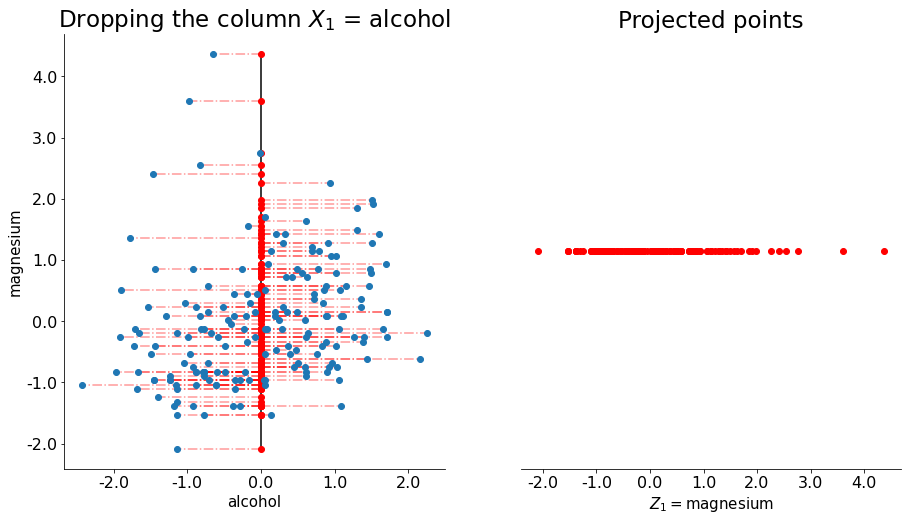

In [26]:
plot_reduction2d(wine_std[['alcohol', 'magnesium']], 15, 8, drop = 0) # can try to drop 1 too

## Concept 2: Choosing a line to project on
- In PCA, we're trying to project onto an axis of maximum variance

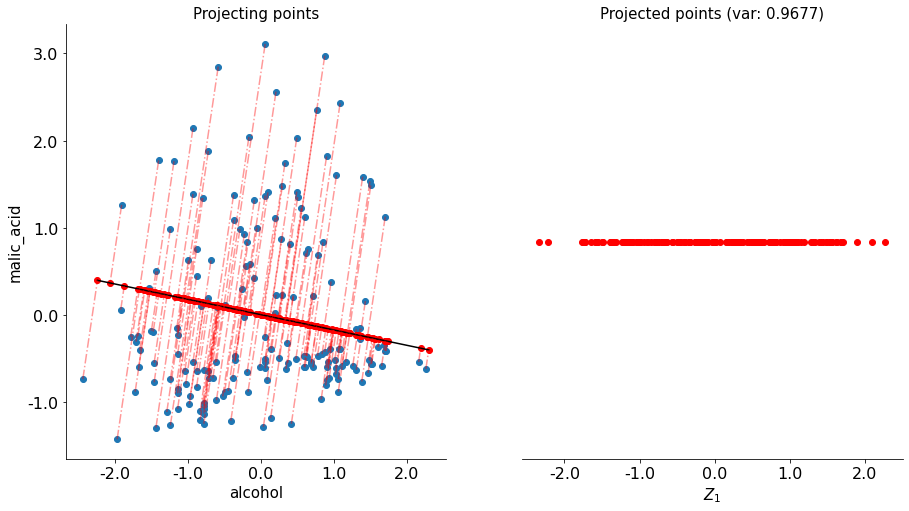

In [38]:
for θ in np.linspace(0,170, 8):
    plot_rotation2d(wine_std, 15, 8, θ, clear=True)
    time.sleep(2)

## Concept 3: Many components

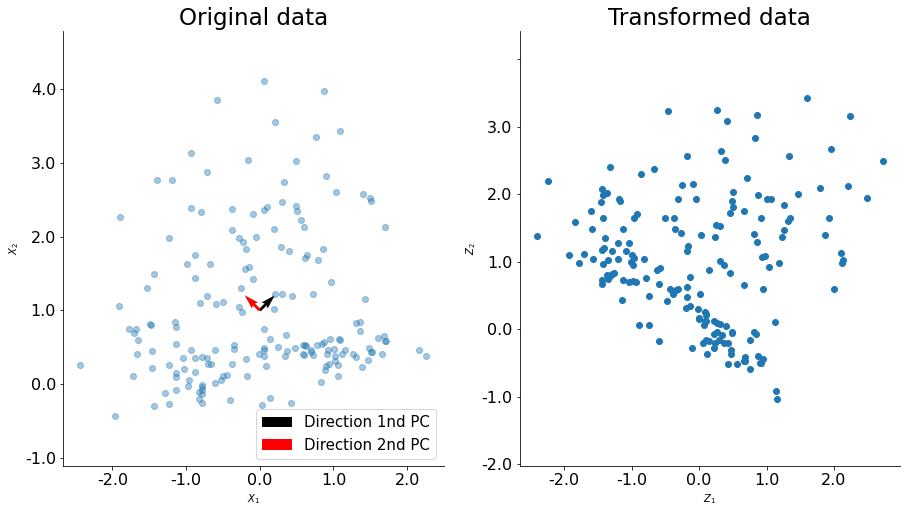

In [44]:
plot_pca_rotation2d(wine_std[['alcohol', 'malic_acid']], 15, 8)

## Mathematically speaking ...

Let $Z$ be our new desired representation.

$$
\textbf{Z}_{(n\times k)} = \textbf{X}_{(n\times d)}\left(\textbf{w}_{(k\times d)}\right)^T
$$

where $1\leq k \leq d$ and $d$ is the dimension of the original dataset.

$$
\left[
  \begin{array}{cccc}
    \rule[-1ex]{0.5pt}{2.5ex} &         & \rule[-1ex]{0.5pt}{2.5ex} \\
    {\textbf{Z}}_{1}    & \ldots & \textbf{Z}_{d}    \\
    \rule[-1ex]{0.5pt}{2.5ex}  &        & \rule[-1ex]{0.5pt}{2.5ex} 
  \end{array}
\right] = 
\left[
  \begin{array}{cccc}
    \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex}    &     & \rule[-1ex]{0.5pt}{2.5ex} \\
    \textbf{X}_{1}    & \textbf{X}_{2}    & \ldots  & \textbf{X}_{d}    \\
    \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex}    &     & \rule[-1ex]{0.5pt}{2.5ex} 
  \end{array}
\right]\underbrace{\left[
  \begin{array}{cccc}
    \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} &        & \rule[-1ex]{0.5pt}{2.5ex} \\
    \textbf{PC}_{1}    & \textbf{PC}_{2}    & \ldots  & \textbf{PC}_{d}    \\
    \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} &        & \rule[-1ex]{0.5pt}{2.5ex} 
  \end{array}
\right]}_{\left(\textbf{w}_{(d\times d)}\right)^T}
$$

(Each PC is an eigenvector, this is why we learned about eigen-things)

## The code
- Let's just use the first 3 features

In [45]:
X = wine_std.iloc[:, 0:3].to_numpy()
X[0:5, :]

array([[ 1.51861254, -0.5622498 ,  0.23205254],
       [ 0.24628963, -0.49941338, -0.82799632],
       [ 0.19687903,  0.02123125,  1.10933436],
       [ 1.69154964, -0.34681064,  0.4879264 ],
       [ 0.29570023,  0.22769377,  1.84040254]])

In [48]:
X.shape

(178, 3)

Let's fit a PCA, turning our $X$ into $Z$

In [46]:
# PCA object will fit a PCA for us
pca = PCA()

# Learning the components and transforming X into Z
Z = pca.fit_transform(X)

print(Z[0:5, :])

[[-0.74288937 -1.35859608 -0.52772089]
 [ 0.64174121 -0.45223797 -0.61587276]
 [-0.83794212 -0.22221255  0.7199371 ]
 [-1.11568165 -1.31345903 -0.49976974]
 [-1.46913532 -0.19525223  1.15320535]]


In [47]:
Z.shape

(178, 3)

What is our $w$? They are our components.

In [49]:
# This is our w (the components row-wise)
w = pca.components_
print(w)

[[-0.57714314 -0.50306233 -0.64329937]
 [-0.57817425  0.80802739 -0.1131648 ]
 [-0.57673246 -0.30662685  0.75720515]]


In [50]:
w.shape

(3, 3)

Let's make sure it checks out...

In [51]:
# Sanity check:
print(Z[0:5, :])

[[-0.74288937 -1.35859608 -0.52772089]
 [ 0.64174121 -0.45223797 -0.61587276]
 [-0.83794212 -0.22221255  0.7199371 ]
 [-1.11568165 -1.31345903 -0.49976974]
 [-1.46913532 -0.19525223  1.15320535]]


In [52]:
(X @ w.T)[0:5, :]

array([[-0.74288937, -1.35859608, -0.52772089],
       [ 0.64174121, -0.45223797, -0.61587276],
       [-0.83794212, -0.22221255,  0.7199371 ],
       [-1.11568165, -1.31345903, -0.49976974],
       [-1.46913532, -0.19525223,  1.15320535]])

## The whole point is dimensionality *reduction*
- How many components do I pick?

In [53]:
# Variance explained
pca.explained_variance_ratio_

array([0.4393579 , 0.30316024, 0.25748186])

## Fitting PCA on the whole dataset

In [54]:
wine_std.shape

(178, 13)

In [55]:
# Run PCA on the wine dataset
pca_wine = PCA(n_components=13)
pca_wine.fit(wine_std) # notice I only do fit here

PCA(copy=True, iterated_power='auto', n_components=13, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Plotting variance explained - Elbow Plot
- How many components do I use?

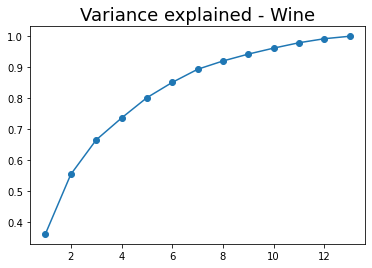

In [66]:
# Calculates the proportion of variance explained
var_exp_wine = np.cumsum(pca_wine.explained_variance_/np.sum(pca_wine.explained_variance_))

# Plots the elbow plot for the wine pca
plt.plot(range(1,14), var_exp_wine, marker='o')
plt.title("Variance explained - Wine", fontsize=18);

## Linear Discriminant Analysis
- Similar to PCA: Projecting onto smaller number of dimensions
- Different from PCA: Uses the `y` or class label to help us decide what to select
- Can only use for classification (remember, when `y` is discrete)

<img src='imgs/pca-v-lda.png' width=700>

## Introducing the Iris dataset

<img src='imgs/iris-dataset.png'>

## LDA: concept of interclass variance
- Which features better delineates the classes?

<img src='imgs/lda-iris.png' width=800>

**We are trying to find components that minimize the inter-class variance and maximizes the intra-class variance**

## The code: import iris

In [69]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


## The code: some data prep

In [75]:
X = df.drop(['class label'], axis=1).values
y = df['class label'].values

# creating dummy variables
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

## The code: LDA

In [96]:
# LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

In [97]:
X_lda.shape

(150, 2)

In [98]:
lda.coef_.shape # number of classes by number of features

(3, 4)

## PCA vs. LDA comparison for iris

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

## Variable Selection
- PCA and LDA are sophisticated ways to try to "pack more data into less dimensions"
- The challenge is explainability: we no longer really know what the dimensions represent

### Why variable selection?
- Other variable selection techniques exist to maintain explainability while downselecting variables
- They require less computational time and may perform just as well
- A simple example is just picking the best 10 out of the 20 features that are available

## Back to our old example
- What would be the features we would pick for the `iris` dataset?

<img src='imgs/lda-iris.png' width=800>

# Break

Let's reconvene in ...

## Variable Selection Techniques

**Filter methods**
   - Using correlation and other metrics to select variables during data prep
   
**Wrapper methods**
   - "Try (on a model), measure and try (fitting the model) again"
   - Techniques like backward selection, forward selection
   
**Embedded methods (will cover on Friday)**
   - Altering the algorithm itself to weed out variables that aren't useful
    
Usually some combination of all three are used / tried over the entire machine learning process.

## Variable Selection - Filter Method Example
- Remember our Boston Housing dataset?

In [110]:
boston_housing  = load_boston()
boston_df = pd.DataFrame(boston_housing.data, columns=boston_housing.feature_names)
boston_df['target'] = boston_housing.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Using correlation
- Looking for variables that are highly correlated with target
- Eliminating variables that are highly correlated with each other

In [111]:
# Get pair-wise correlation between features and features and target
cor = boston_df.corr()
cor

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


### Correlation heat map
- Much easier to see

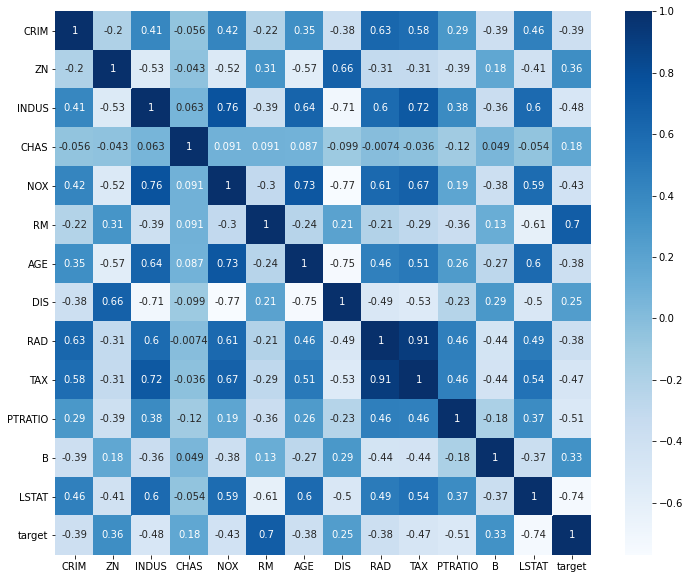

In [113]:
plt.figure(figsize=(12,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

## Drawbacks of using correlation

- Ignores variable interactions
- Looking at feature combinations independently

## Variable Selection - Wrapper Method
- Remember that wrapper method uses a "try and see" approach for a given model
- **Forward Selection**: Start with having no features in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.
- **Backward Elimination**: Start with all the features and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.
- **Recursive Feature elimination**: ... next slide

## Variable Selection - Wrapper Method continued...
### Recursive Feature Elimination

1. Decide $k$, the number of features to select. 
* Use a model (usually a linear model) to assign weights to features.
    - The weights of important features have higher absolute value.
* Rank the features based on the absolute value of weights.
* Drop the least useful feature.
* Try steps 2-4 again until desired number of features is reached

## Variable Selection - Wrapper Methods Tips
- Look for implementations, `sklearn` has a `rfe` implementations, for example
- It's not possible to tell which method will work better until you try
- Different variable selection algorithms may give you a different answers
- Different machine learning algorithms with the same variable selection method may give you given answers
- Over this process, you'll find out what features tend to get eliminated and which features tend to be kept (hopefully)